In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
import os

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [12]:
#PATH_P = "Machine_Learning/Parasitized"
#PATH_U = "Machine_Learning/Uninfected"#

#parasitized_path = "Parasitized"
#uninfected_path = "Uninfected"

#parasitized_ids = next(os.walk(PATH_P))
#uninfected_ids = next(os.walk(PATH_U))

#ids = parasitized_ids+uninfected_ids

In [13]:
#os.listdir('/Parasitized')

from PIL import Image
import os, sys

path = ('Parasitized/')
def resize():
    i=0
    for item in os.listdir(path):
        print(item)
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            #print(im)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((4,4), Image.ANTIALIAS)
            imResize.save('Resized_img_4x4/'+f + ' resized.jpg', 'JPEG', quality=90)
            #imResize.show()
            i+=1
            print('resized',i)
            if i==1000:
                break
resize()
print()
print("Total images:",i)

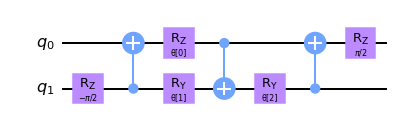

In [3]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

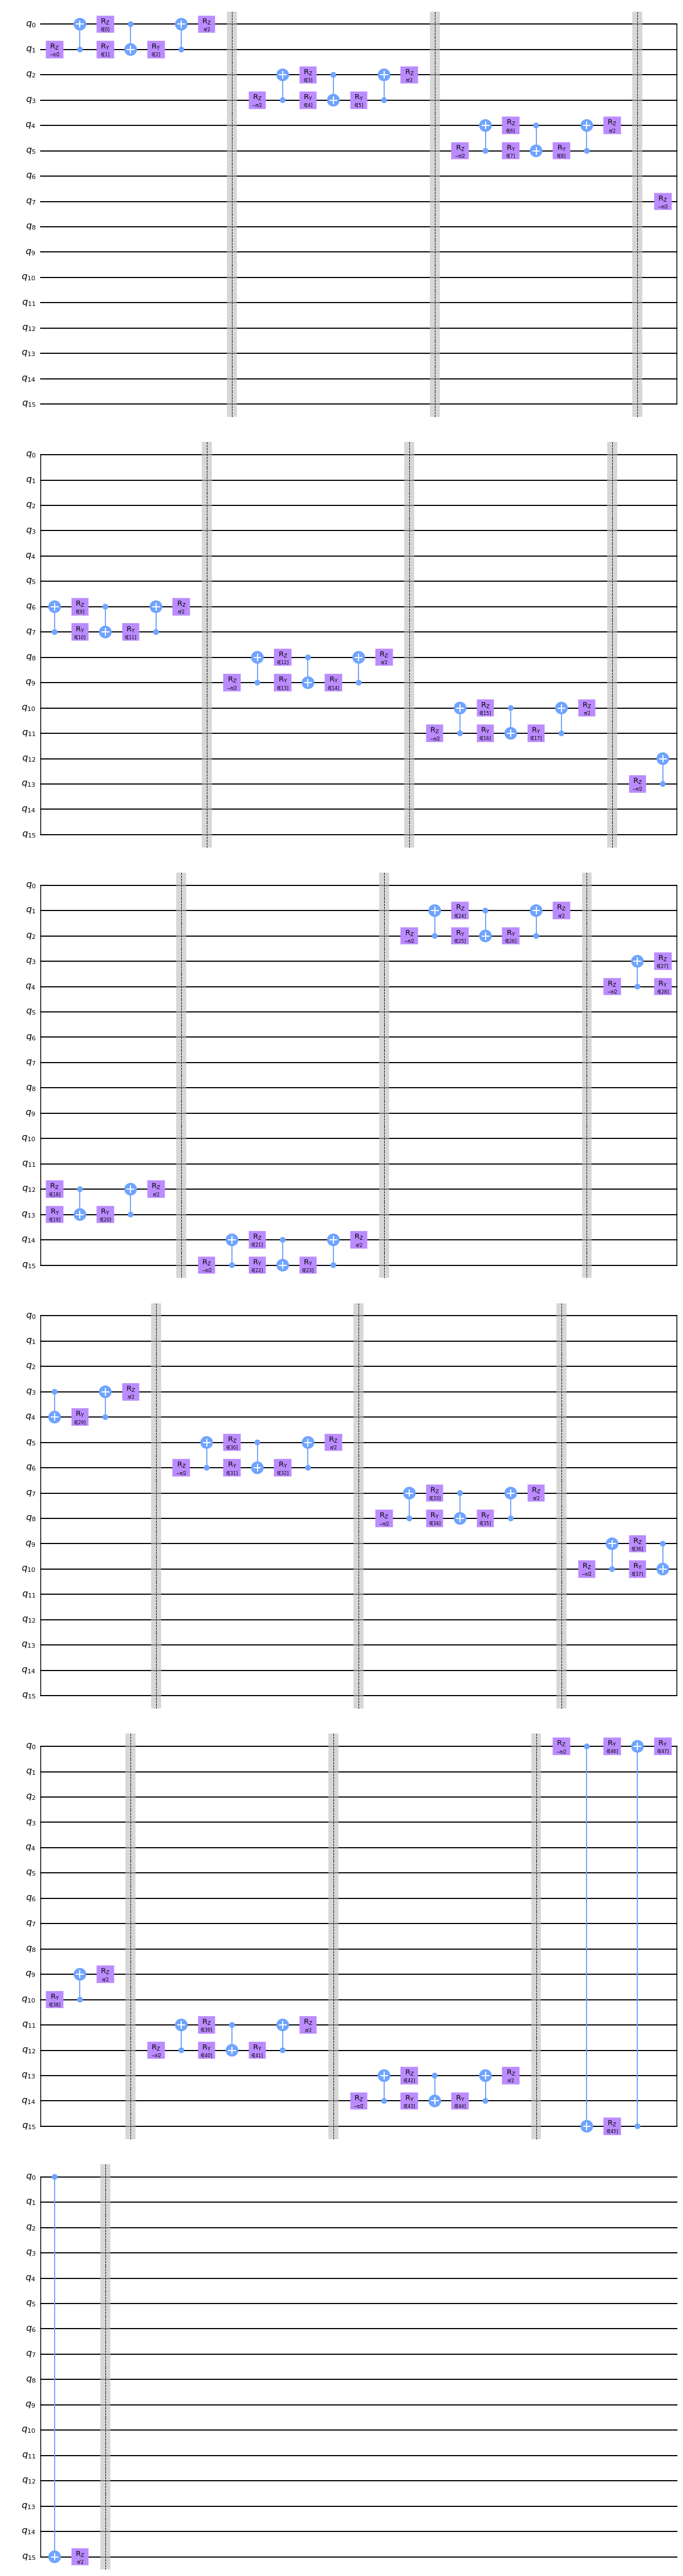

In [4]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(16, "θ")
circuit.decompose().draw("mpl")

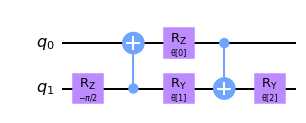

In [5]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

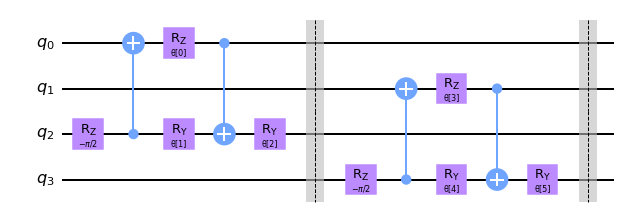

In [6]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [7]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [8]:
images, labels = generate_dataset(2)
images

[array([1.57079633, 0.24878142, 0.62624937, 0.53112918, 1.57079633,
        0.30717672, 0.26139145, 0.4699106 ]),
 array([0.52838136, 1.57079633, 1.57079633, 0.73969024, 0.19497173,
        0.74524951, 0.52404707, 0.07531806])]

In [9]:
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 9.0.1


In [14]:
#from PIL import Image
# Open the image form working directory
#image = Image.open('kolala.jpeg')
# summarize some details about the image
#print(image.format)
##print(image.size)
#print(image.mode)
# show the image
#load_image.show()

In [11]:
from PIL import Image
import os, sys
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray
# load image as pixel array
parasitized = []
uninfected = []
path_p = ('Resized_img_4x4/Parasitized/')
path_u = ('Resized_img_4x4/Uninfected/')
def load_im(path):
    i=0
    data = []
    for item in os.listdir(path):
        #print(item)
        if os.path.isfile(path+item):
            img = Image.open(path+item)
            #print(im)
            #f, e = os.path.splitext(path+item)
            #imResize = im.resize((4,2), Image.ANTIALIAS)
            #imResize.save('Resized_img/'+f + ' resized.jpg', 'JPEG', quality=90)
            #imResize.show()
            i+=1
            #print('resized',i)
            if i%100==0:
            #   break
                print(i,path)
            
            #print(img.format)
                print(img.size)
            #print(img.mode)
            # show the image
            #image.show()
            #data = asarray(img)
            im = np.array(Image.open(path+item).convert('L'))
            #print(im[0],im[1])
            im = np.array(np.concatenate((im[0],im[1],im[2],im[3])))
            
            data.append(im)
            
            
            # Visualizing using matplorlib
            #imag = image.imread(path+item)
            # summarize shape of the pixel array
            #print(imag.dtype)
            #print(imag.shape)
            # display the array of pixels as an image
            #pyplot.imshow(imag)
            #pyplot.show()
            if i==100:
                break
    return data
            
parasitized = load_im(path_p)
uninfected = load_im(path_u)
print(len(parasitized),len(uninfected))

100 Resized_img_4x4/Parasitized/
(4, 4)
100 Resized_img_4x4/Uninfected/
(4, 4)
100 100


In [15]:
labels = [1 for i in range(100)]

In [16]:
labels+=[-1 for i in range(100)]

In [17]:
images = parasitized+uninfected

In [18]:
len(images),len(labels)

(200, 200)

In [19]:
#images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3,shuffle=True
)
train_images[0].shape,train_labels[:10]

((16,), [-1, -1, -1, -1, -1, -1, 1, -1, 1, -1])

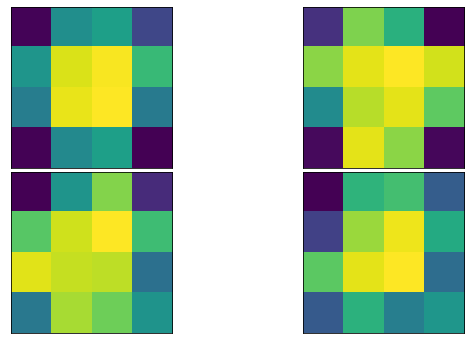

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(4, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

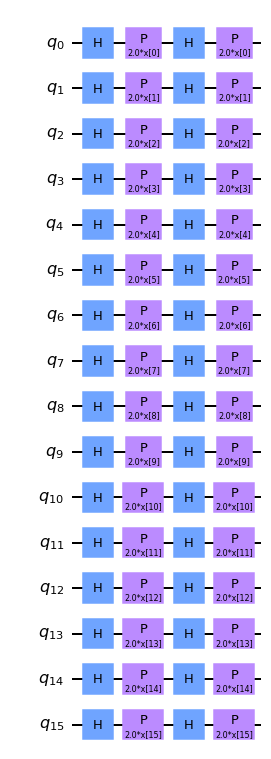

In [21]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

In [22]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [23]:
feature_map = ZFeatureMap(16)

ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer(range(0,8), range(8,16), "p1"), list(range(16)), inplace=True)

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с2"), list(range(8,16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8,16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z"*8+ "I" * 8, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

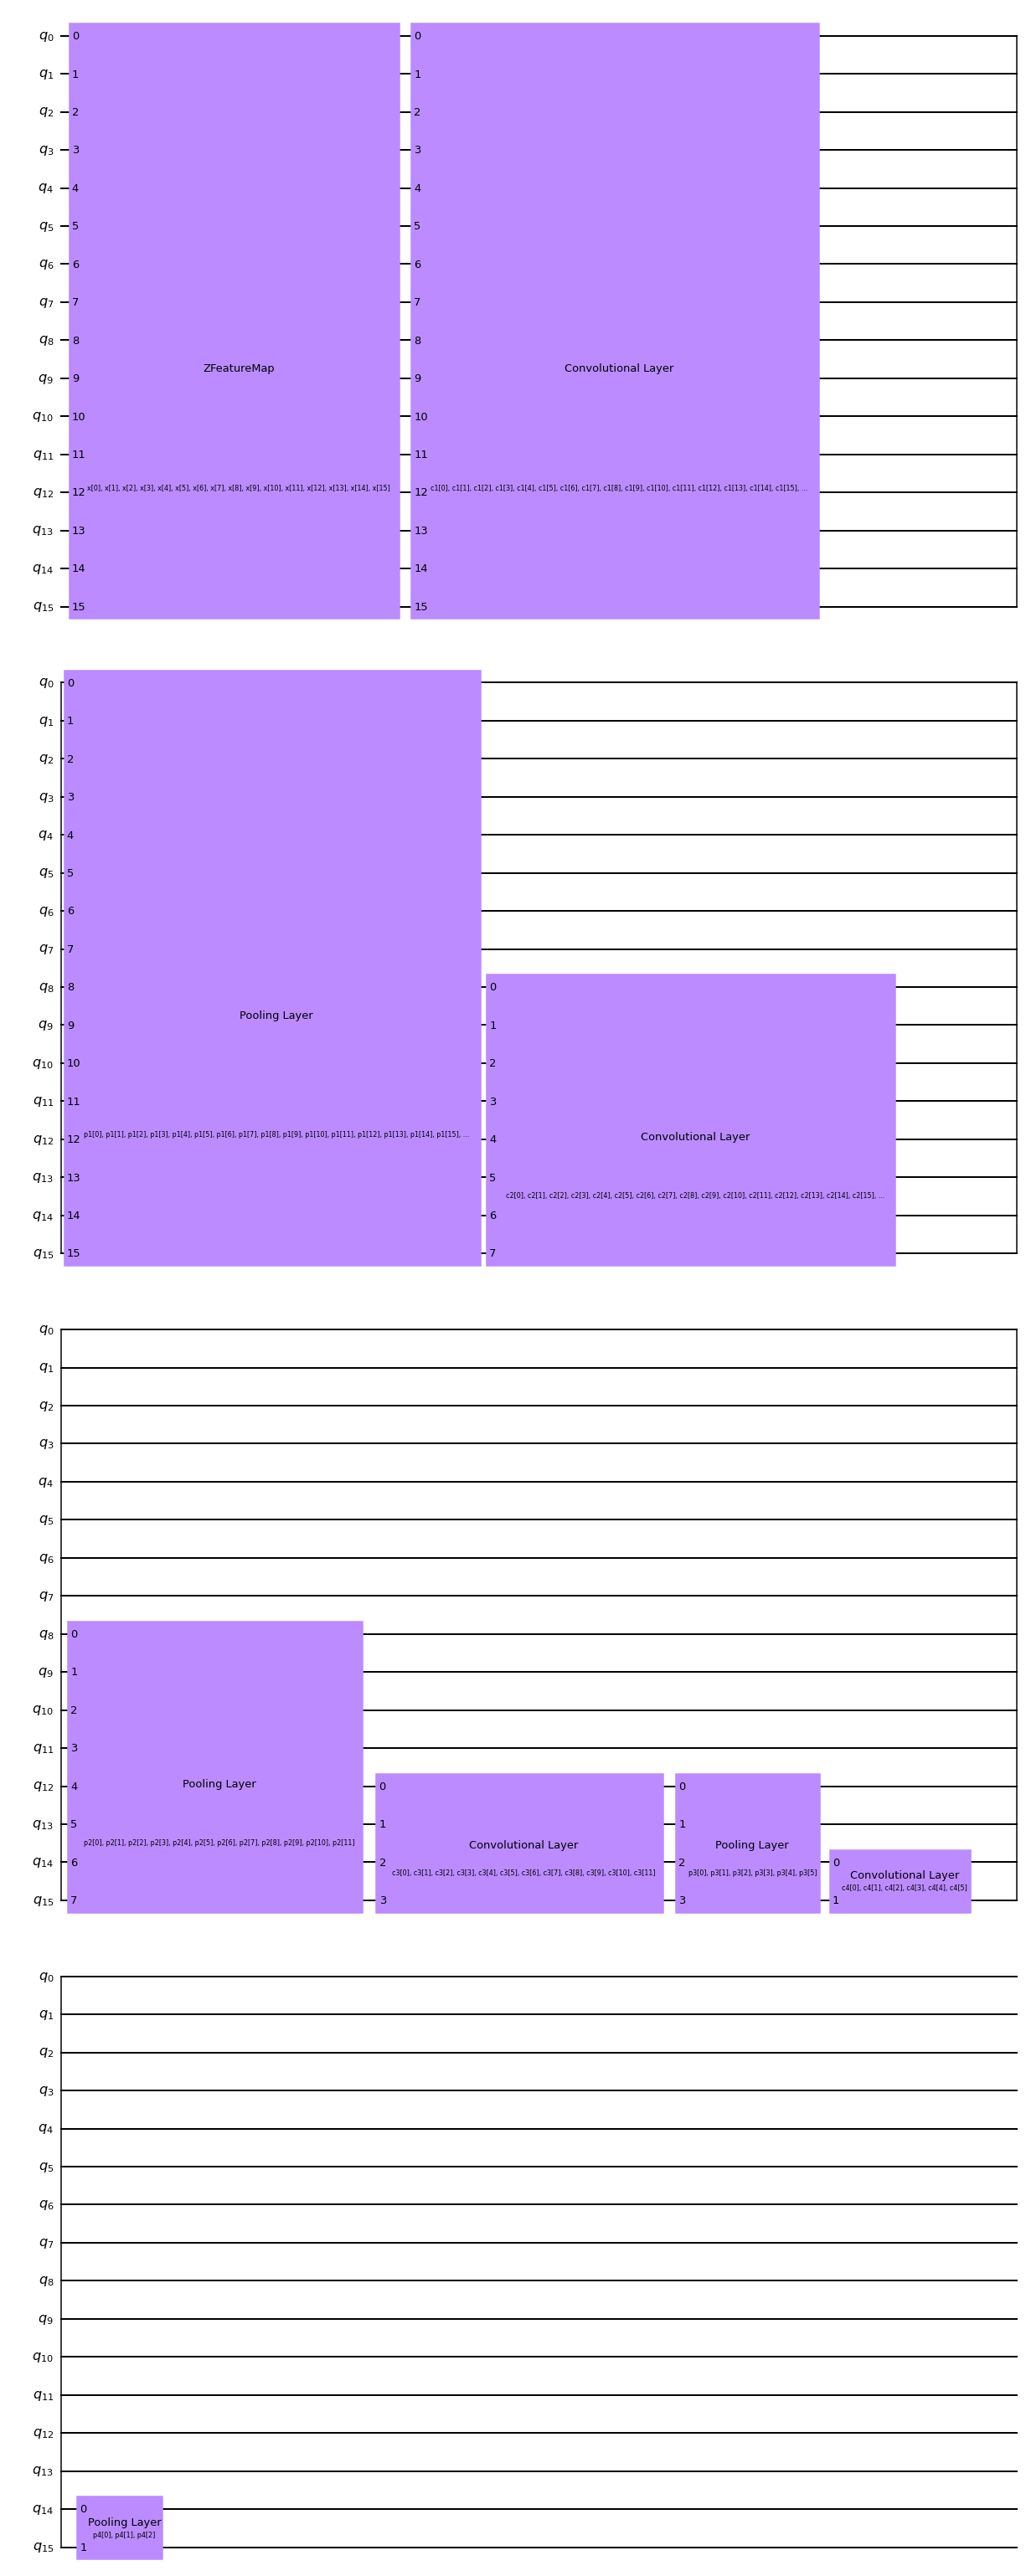

In [24]:
circuit.draw("mpl")

In [25]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [26]:
#with open("11_qcnn_initial_point.json", "r") as f:
#    initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
    #initial_point=initial_point,
)

In [27]:
x = np.asarray(train_images)
y = np.asarray(train_labels)
print(x[0].shape)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

(16,)


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

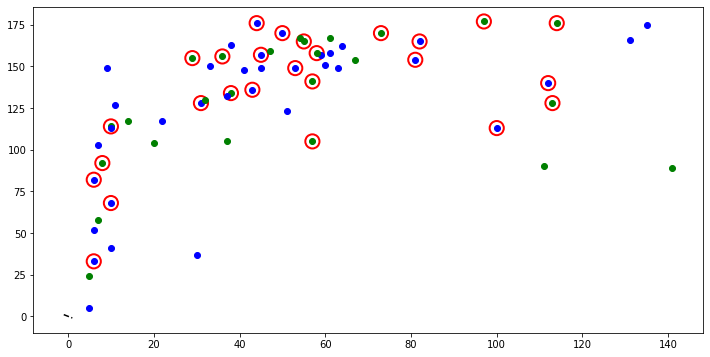

In [43]:
# evaluate data points
y_predict = classifier.predict(test_images)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(test_images, test_labels, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


In [46]:
from sklearn.metrics import confusion_matrix,accuracy_score
print("Testing results:")
confusion_matrix(test_labels, y_predict)
accuracy_score(test_labels,y_predict)

Testing results:


0.5666666666666667

60